In [1]:
import lightgbm as lgb
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from mlxtend.regressor import StackingCVRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
df = pd.read_csv("data.csv")
display(df[:5])

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
## Check the unique number in each column
for i in df:
    print(i + " unique number is" , len(df[i].unique()))

Sex unique number is 3
Length unique number is 134
Diameter unique number is 111
Height unique number is 51
Whole weight unique number is 2429
Shucked weight unique number is 1515
Viscera weight unique number is 880
Shell weight unique number is 926
Rings unique number is 28


In [4]:
## I found the dataset has another description told the ring feature add 1.5 gives the age in years
df["Age"] = df['Rings'] + 1.5
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684,11.433684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000,2.500000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000,9.500000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000,10.500000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000,12.500000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,30.500000


In [5]:
## From the above table, I found Height column have some 0 value. Remove it.
df = df[df['Height']>0]
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age
count,4175.000000,4175.00000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000
mean,0.524065,0.40794,0.139583,0.829005,0.359476,0.180653,0.238834,9.935090,11.435090
std,0.120069,0.09922,0.041725,0.490349,0.221954,0.109605,0.139212,3.224227,3.224227
min,0.075000,0.05500,0.010000,0.002000,0.001000,0.000500,0.001500,1.000000,2.500000
25%,0.450000,0.35000,0.115000,0.442250,0.186250,0.093500,0.130000,8.000000,9.500000
50%,0.545000,0.42500,0.140000,0.800000,0.336000,0.171000,0.234000,9.000000,10.500000
75%,0.615000,0.48000,0.165000,1.153500,0.502000,0.253000,0.328750,11.000000,12.500000
max,0.815000,0.65000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,30.500000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000198CEDD8>,
      dtype=object)

<Figure size 1440x1440 with 0 Axes>

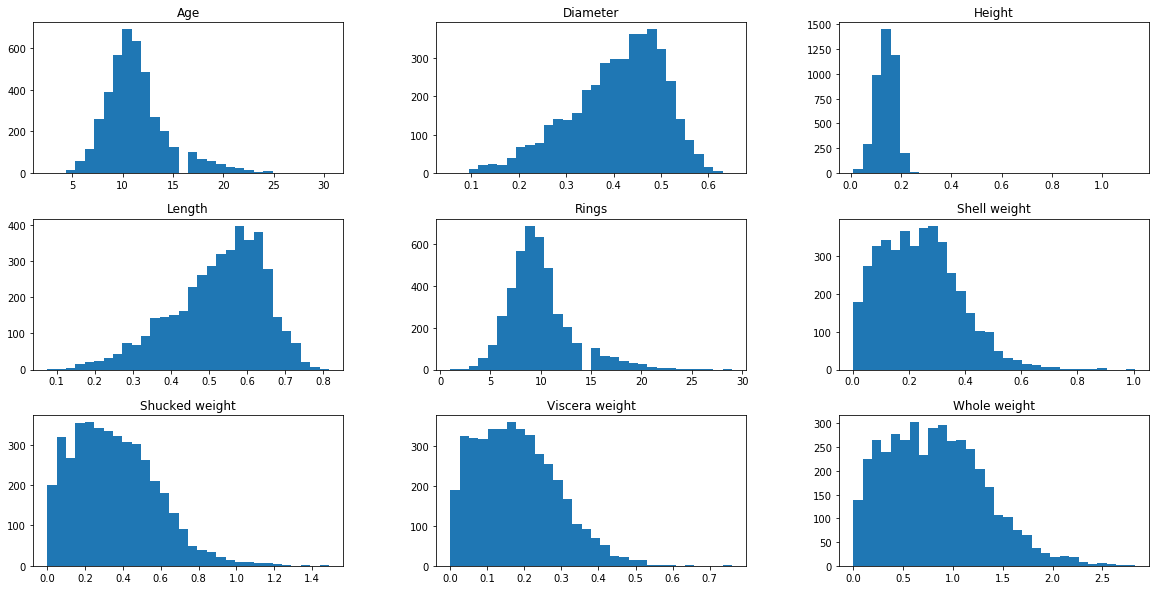

In [6]:
plt.figure(figsize=(20,20))
df.hist(figsize=(20,10), grid=False, bins = 30)

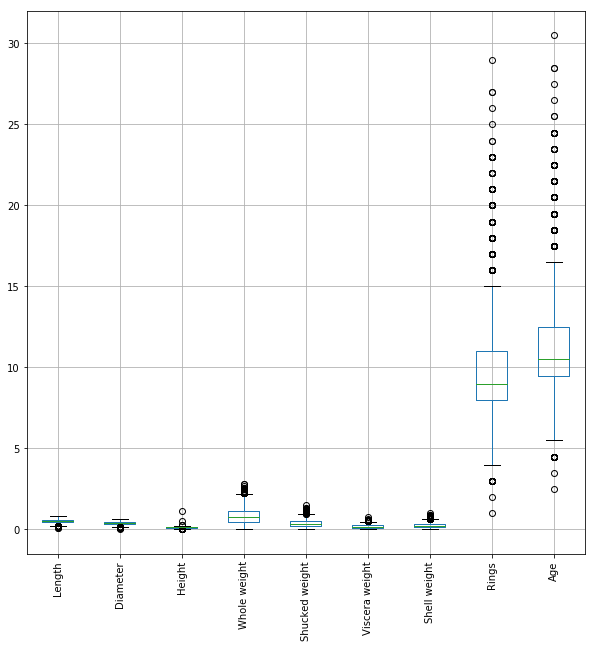

In [7]:
plt.figure(figsize=(10,10))
# for i in df.columns:
#     print(i)
#     plt.subplot(3, 3, count)
#     sns.boxplot(df[i])
#     count += 1
df.boxplot(rot = 90, figsize=(20,20))

In [8]:
df.skew().sort_values()

Length           -0.640993
Diameter         -0.610182
Whole weight      0.530549
Viscera weight    0.591455
Shell weight      0.621081
Shucked weight    0.718735
Rings             1.113754
Age               1.113754
Height            3.166364
dtype: float64

In [12]:
df[["Length", "Diameter", "Height", "Whole weight", "Shucked weight","Viscera weight", "Shell weight", "Rings","Age"]].corr()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age
Length,1.000000,0.986794,0.900868,0.925328,0.898129,0.903033,0.898363,0.556572,0.556572
Diameter,0.986794,1.000000,0.907187,0.925499,0.893330,0.899716,0.906026,0.574551,0.574551
Height,0.900868,0.907187,1.000000,0.888850,0.837485,0.866757,0.891857,0.610107,0.610107
Whole weight,0.925328,0.925499,0.888850,1.000000,0.969370,0.966290,0.955954,0.540621,0.540621
Shucked weight,0.898129,0.893330,0.837485,0.969370,1.000000,0.931831,0.883194,0.421156,0.421156
Viscera weight,0.903033,0.899716,0.866757,0.966290,0.931831,1.000000,0.908133,0.503977,0.503977
Shell weight,0.898363,0.906026,0.891857,0.955954,0.883194,0.908133,1.000000,0.628169,0.628169
Rings,0.556572,0.574551,0.610107,0.540621,0.421156,0.503977,0.628169,1.000000,1.000000
Age,0.556572,0.574551,0.610107,0.540621,0.421156,0.503977,0.628169,1.000000,1.000000


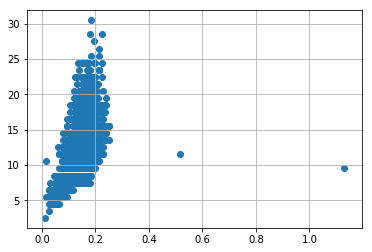

In [9]:
plt.scatter(x = df["Height"], y = df["Age"])
plt.grid(True)

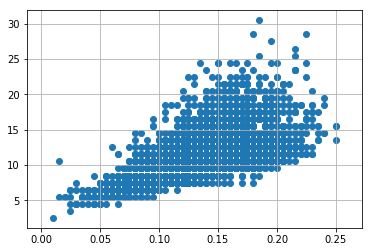

In [10]:
## Delete outlier in height-age
df = df[ df[ "Height"]<0.4]
plt.scatter(x = df["Height"], y = df["Age"])
plt.grid(True)
